In [6]:
#Что было сделано:
1. Категоризовали признаки с помощью OHE, отнормировали данные с помощью RobustScaler
2. Проверили работу sklearn linear, sgdregress на кросс валидации (KFold вручную и sklearn.cross_val_score)
3. Проверили работу с регуляризацией + подбором параметров через gridsearchCV
4. Выведена корреляционная матрица, проверена работа PCA + результаты на предсказаний на PCA.
5. Проверена svm с разными ядрами + gridsearch

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../input/car-price-prediction/CarPrice_Assignment.csv")

In [4]:
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [3]:
#Хотим создать список категориальных переменных, которые будет необходимо закодировать
categorial = []
data.car_ID.dtypes
for i in data:
    if data[i].dtypes == "object":
        categorial.append(str(i))

In [4]:
#Удалим CarName и добавим symboling, тк это тоже категориальная, хоть и int типа.
categorial.append("symboling")
categorial.pop(0)
data.drop(["CarName", "car_ID"], axis = 1, inplace = True)
categorial

['fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'symboling']

In [5]:
#Теперь разделим выборку на train и test, X_ выборки поделим на категориальные и нет, чтобы сделать OHE и RobustScaler а затем конкатинировать обратно
import sklearn
from sklearn.model_selection import train_test_split
X = data.iloc[:, :23]
Y = data.iloc[:, 23]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 51, shuffle = True,)


In [8]:
cat_train = X_train[categorial]
cat_test = X_test[categorial]

In [6]:
numeric_train = X_train.drop(categorial, axis = 1)
numeric_test = X_test.drop(categorial, axis = 1)

In [9]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
OHE = OneHotEncoder()
Scaler = RobustScaler()
z1 = OHE.fit_transform(cat_train)
z2 = OHE.transform(cat_test)
z3 = Scaler.fit_transform(numeric_train)
z4 = Scaler.transform(numeric_test)
x_train = pd.concat([pd.DataFrame(z1.toarray()), pd.DataFrame(z3)], axis = 1)
x_test = pd.concat([pd.DataFrame(z2.toarray()), pd.DataFrame(z4)], axis = 1)

In [11]:
#Теперь проверим вручную LinearRegression на KFold и cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = LinearRegression()
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))
    


In [12]:
#Посмотрим на scor'ы модели (метрика MSE). Ошибки большие + большой разброс по фолдам.
score

[2851.8572793963713, 1121405904357941.1, 251281880720310.3, 56072721625787.46]

In [199]:
np.mean(score)

357190126676722.7

In [186]:
#Проверим как справится случайный лес
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score_rf = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = RandomForestRegressor(n_estimators = 30000)
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score_rf.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))
    


In [187]:
#Ошибки значительно меньше, а значит действительно линейный алгоритм слабо апроксимирует исходную зависимость.
score_rf

[1784.9550338619945,
 1998.0089887416452,
 2584.2048140331945,
 2634.0852366882036]

In [209]:
#То же самое функцией cross_val_score
from sklearn.model_selection import cross_val_score
model = LinearRegression()
results = cross_val_score(model, x_train, Y_train, cv = 4, scoring = "neg_root_mean_squared_error")
results

array([-6.99889200e+14, -1.05464970e+15, -3.73526991e+03, -3.81274145e+03])

In [211]:
results.mean()

-438634725256748.2

In [13]:
#То же самое SGDRegressor (параметры не подбирались)
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score_SGD = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = SGDRegressor(max_iter = 2000, random_state = 55)
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score_SGD.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))
    


In [14]:
score_SGD

[4340.8912044599065, 2393.820994371467, 3234.517428360596, 3482.16274945402]

In [23]:
np.mean(score_SGD)

3362.848094161497

In [16]:
#Попробуем подобрать параметры на SGDRegressor с помощью gridsearchCV
from sklearn.model_selection import GridSearchCV
model = SGDRegressor()
parametrs = { 'penalty': ["l2", "l1", "elasticnet"],
              'alpha': [0, 0.0001, 0.001, 0.1, 0.2],
              'l1_ratio': [0.15, 0.30, 0.50],
              'max_iter': [1000, 2000, 3000, 5000, 7000],
               "shuffle": [True],
            "random_state": [55],
            "learning_rate": ["optimal", "invscaling"],
            "eta0": [0.01, 0.05, 0.1, 0.005] }
grid = GridSearchCV(model, parametrs, cv=4)
grid.fit(x_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linea

GridSearchCV(cv=4, estimator=SGDRegressor(),
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1, 0.2],
                         'eta0': [0.01, 0.05, 0.1, 0.005],
                         'l1_ratio': [0.15, 0.3, 0.5],
                         'learning_rate': ['optimal', 'invscaling'],
                         'max_iter': [1000, 2000, 3000, 5000, 7000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [55], 'shuffle': [True]})

In [17]:
#Выведем лучшие параметры
grid.best_params_

{'alpha': 0.001,
 'eta0': 0.005,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'max_iter': 1000,
 'penalty': 'l2',
 'random_state': 55,
 'shuffle': True}

In [19]:
#Посмотрим насколько изменилось качество с этими параметрами
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score_SGD_tuned = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = SGDRegressor(max_iter = 1000, random_state = 55, shuffle = True, penalty = "l2", learning_rate = "invscaling", eta0 = 0.005, alpha = 0.001)
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score_SGD_tuned.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))
    


In [20]:
score_SGD_tuned

[4297.3433410637535, 2417.008325124252, 3207.0486881980646, 3451.93583761014]

In [22]:
#Ошибка уменьшилась незначительно
np.mean(score_SGD_tuned)

3343.334047999053

In [25]:
#Теперь посмотрим на корр. матрицу у int признаков. Мультикорр есть а значит можно попробовать PCA
import matplotlib.pyplot as plt

corr = pd.DataFrame(z3).corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,0.878698,0.818675,0.574604,0.802590,0.613445,0.498195,0.183242,0.254290,0.384914,-0.346237,-0.493286,-0.569740
1,0.878698,1.000000,0.845859,0.502777,0.885636,0.698796,0.600670,0.159113,0.152344,0.571407,-0.250076,-0.697851,-0.732763
2,0.818675,0.845859,1.000000,0.295564,0.867471,0.740523,0.575706,0.195599,0.179162,0.673318,-0.172786,-0.658619,-0.688989
3,0.574604,0.502777,0.295564,1.000000,0.309617,0.086395,0.163098,-0.047918,0.270421,-0.109474,-0.357483,-0.047819,-0.105769
4,0.802590,0.885636,0.867471,0.309617,1.000000,0.847460,0.654541,0.205195,0.157779,0.753150,-0.243706,-0.759518,-0.798482
5,0.613445,0.698796,0.740523,0.086395,0.847460,1.000000,0.589055,0.232046,0.019704,0.809384,-0.230879,-0.650207,-0.674937
6,0.498195,0.600670,0.575706,0.163098,0.654541,0.589055,1.000000,-0.017099,0.035281,0.576496,-0.255036,-0.586511,-0.605103
7,0.183242,0.159113,0.195599,-0.047918,0.205195,0.232046,-0.017099,1.000000,0.189283,0.121121,-0.044296,-0.063349,-0.064590
8,0.254290,0.152344,0.179162,0.270421,0.157779,0.019704,0.035281,0.189283,1.000000,-0.202204,-0.473114,0.297327,0.243800
9,0.384914,0.571407,0.673318,-0.109474,0.753150,0.809384,0.576496,0.121121,-0.202204,1.000000,0.157451,-0.801161,-0.766737


In [26]:
#Используем PCA
nums =  pd.DataFrame(z3)
from sklearn.decomposition import PCA
pca = PCA(n_components = 13, random_state = 55)
pca.fit_transform(nums)
print("variance explained by all 13 components =", sum(pca.explained_variance_ratio_ * 100))


variance explained by all 13 components = 100.00000000000001


In [27]:
#Посмотрим сколько % дисперсии объясняет каждая компонента. Видим, что уже 77% объясняет всего одна переменная
pca.explained_variance_ratio_ * 100

array([7.72285634e+01, 1.34597258e+01, 3.21748293e+00, 2.43880695e+00,
       1.22686483e+00, 6.75047440e-01, 5.88402911e-01, 4.11540439e-01,
       3.15938452e-01, 1.79785438e-01, 1.55334135e-01, 8.37470818e-02,
       1.87601458e-02])

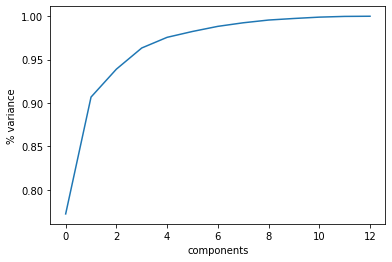

In [28]:
#Нарисуем график 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("components")
plt.ylabel("% variance")
plt.show()

In [41]:
#возьмем 3 главные компоненты
pca = PCA(n_components = 3, random_state = 55)
new_z3_train = pca.fit_transform(nums)
x_train = pd.concat([pd.DataFrame(z1.toarray()), pd.DataFrame(new_z3_train)], axis = 1)

In [42]:
#Качество с подобранными гиперпараметрами + PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score_SGD_tuned_PCA = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = SGDRegressor(max_iter = 1000, random_state = 55, shuffle = True, penalty = "l2", learning_rate = "invscaling", eta0 = 0.005, alpha = 0.001)
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score_SGD_tuned_PCA.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))
    


In [43]:
score_SGD_tuned_PCA

[5036.933961102572, 2448.2666110811992, 3494.5998130657454, 3978.091303946341]

In [ ]:
#Ошибка повысилась (не критично, при 6 компонентах понижается до 3531)
np.mean(score_SGD_tuned_PCA)

In [11]:
#Проверим SVM
from sklearn.svm import SVR
model = SVR()
from sklearn.model_selection import GridSearchCV
parametrs = { 'kernel': ["linear", "poly", "rbf", "sigmoid"],
              'degree': [3, 4, 6, 15],
              'C': [1.0, 0.95, 0.9] }
grid = GridSearchCV(model, parametrs, cv=4)
grid.fit(x_train, Y_train)

GridSearchCV(cv=4, estimator=SVR(),
             param_grid={'C': [1.0, 0.95, 0.9], 'degree': [3, 4, 6, 15],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [12]:
grid.best_params_

{'C': 1.0, 'degree': 3, 'kernel': 'linear'}

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
folds = KFold(n_splits = 4, shuffle = True, random_state = 55)
score_SVR_tuned = []
for fold, (train_idx, val_idx) in enumerate(folds.split(x_train, Y_train)):
    model = SVR(kernel = "linear", C = 1.0, degree = 3)
    model.fit(x_train.iloc[train_idx], Y_train.iloc[train_idx])
    preds = model.predict(x_train.iloc[val_idx])
    score_SVR_tuned.append(mean_squared_error(Y_train.iloc[val_idx], preds, squared = False))

In [14]:
score_SVR_tuned

[9262.952469301674, 8359.534436442304, 6228.639198597462, 9531.142258593403]

In [15]:
#Ошибка выше
np.mean(score_SVR_tuned)

8345.567090733712